## Text Summarization  ✨

**In this notebook, we'll embark on a text summarization journey using the powerful t5 model from Hugging Face's Transformers library!** 


Here, we'll import the essential libraries and verify CUDA availability for potential GPU acceleration.


In [1]:
import os
import re
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset, load_from_disk
from rouge import Rouge
import torch
import subprocess
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

c:\Users\Admin\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check for CUDA Availability


In [2]:
# Check for CUDA availability

print("Available torch Version",torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of CUDA devices:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device")

if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.rand(3, 3).cuda()
    print("Tensor on GPU:", tensor)
else:
    print("CUDA is not available")


def print_nvidia_smi():
    try:
        # Run the nvidia-smi command
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Check if the command was successful
        if result.returncode == 0:
            print("nvidia-smi output:\n")
            print(result.stdout)
        else:
            print(f"nvidia-smi failed with error code {result.returncode}")
            print(result.stderr)
    
    except FileNotFoundError:
        print("nvidia-smi command not found. Make sure NVIDIA drivers are installed.")

# Call the function to print nvidia-smi output
print_nvidia_smi()

    

Available torch Version 2.3.1
CUDA available: True
CUDA version: 11.8
Number of CUDA devices: 1
CUDA device name: NVIDIA GeForce GTX 1650 Ti
Tensor on GPU: tensor([[0.4080, 0.5609, 0.6213],
        [0.1396, 0.8344, 0.7236],
        [0.5492, 0.6182, 0.9677]], device='cuda:0')
nvidia-smi output:

Thu Jun 20 15:59:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0    16W /  N/A 

# XSum Dataset (Small Subset)

In [3]:

# XSum Dataset (Small Subset)
dataset_path = "xsum_dataset"

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    # Download and save the full dataset (if needed for future training)
    dataset = load_dataset("xsum")
    dataset.save_to_disk(dataset_path)
    print("Dataset downloaded and saved locally.")
else:
    print("Loading dataset from local disk...")
    dataset = load_from_disk(dataset_path)
    print("Dataset loaded from local disk.")


Loading dataset from local disk...


Dataset loaded from local disk.


## Create a small subset for evaluation and training (adjust split size as needed)

In [ ]:

print("Dataset preparing")

# Create a small subset for evaluation and training (adjust split size as needed)
train_size = 0.6  # Use a small portion for faster evaluation and training
dataset_split = dataset["train"].train_test_split(test_size=1 - train_size, shuffle=True)
train_data = dataset_split["train"]
eval_data = dataset_split["test"]
# print(f"Train data size: {len(train_data)}")
# print(f"Evaluation data size: {len(eval_data)}")
print("done")

In [5]:

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        cleaned_text = clean_text(sample["document"])
        input_ids = tokenize_text(cleaned_text, self.tokenizer).squeeze()
        summary = tokenize_text(sample["summary"], self.tokenizer).squeeze()  # Tokenize the summary as well if needed

        return {"input_ids": input_ids, "labels": summary}


# Define helper functions

In [6]:
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove non-alphanumeric characters
    return text

def tokenize_text(text, tokenizer):
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)["input_ids"]
    return input_ids


# Define evaluation function

In [7]:
def evaluate_model(model, data_loader, tokenizer):
    rouge = Rouge()
    model.eval()  # Set model to evaluation mode

    predictions = []
    references = []
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        # Generate summary
        summary_ids = model.generate(
            input_ids=input_ids, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True
        )
        # Decode summaries
        for summary_id in summary_ids:
            summary = tokenizer.decode(summary_id, skip_special_tokens=True)
            predictions.append(summary)

        for label in labels:
            reference = tokenizer.decode(label, skip_special_tokens=True)
            references.append(reference)

    # Calculate ROUGE score
    rouge_score = rouge.get_scores(predictions, references, avg=True)
    print(f"ROUGE Score: {rouge_score}")
    return rouge_score["rouge-l"]["f"]


# Define summarize function

In [8]:
def summarize_text(text_to_summarize, model, tokenizer):
    cleaned_text = clean_text(text_to_summarize)
    input_ids = tokenize_text(cleaned_text, tokenizer).to(device)

    summary_ids = model.generate(
        input_ids, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


# Define training function with early stopping

In [9]:

def train_model(model, train_data, tokenizer, epochs=2, batch_size=1, gradient_accumulation_steps=5):
    optimizer = Adam(model.parameters(), lr=1e-5)  # Adjust learning rate as needed
    model.train()  # Set model to training mode

    training_loss = []  # Track training loss for visualization (optional)
    best_rouge = 0  # Track best ROUGE score for early stopping (optional)
    patience = 3  # Number of epochs to wait for improvement before stopping (optional)

    for epoch in range(epochs):
        epoch_loss = 0.0

        # Create DataLoader for the training data
        train_dataset = CustomDataset(train_data, tokenizer)
        train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for step, batch in enumerate(train_data_loader):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss / gradient_accumulation_steps  # Normalize loss

            # Backward pass
            loss.backward()

            # Gradient accumulation
            if (step + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()

        # Print training loss
        print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}")
        training_loss.append(epoch_loss)  # Track training loss (optional)

        # Evaluate model on validation set (optional)
        eval_dataset = CustomDataset(eval_data, tokenizer)
        eval_data_loader = DataLoader(eval_dataset, batch_size=1)
        val_rouge = evaluate_model(model, eval_data_loader, tokenizer)

        # Early stopping (optional)
        if val_rouge > best_rouge:
            best_rouge = val_rouge
            patience = 3  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping triggered!")
                break

    return model  # Return the trained model


# Loading Pre-trained Model Selection (T5)

In [10]:

# Pre-trained Model Selection (T5-Tiny)

model_name = "t5-small"
print("Model Loaded sucessfullyy...")
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.to(device)  # Move model to appropriate device


Model Loaded sucessfullyy...


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

# Evaluate the pre-trained model on the evaluation set

In [11]:
# Evaluate the pre-trained model on the evaluation set
eval_dataset = CustomDataset(eval_data, tokenizer)
eval_data_loader = DataLoader(eval_dataset, batch_size=2)
pre_trained_rouge = evaluate_model(model, eval_data_loader, tokenizer)
print(f"\nROUGE Score (Pre-trained Model): {pre_trained_rouge}")

ROUGE Score: {'rouge-1': {'r': 0.3277551949702979, 'p': 0.13708845869406242, 'f': 0.1904599183108296}, 'rouge-2': {'r': 0.08723843496208553, 'p': 0.02817936881311193, 'f': 0.04231583853798179}, 'rouge-l': {'r': 0.2748546101749763, 'p': 0.11607256806107964, 'f': 0.16072211445480394}}

ROUGE Score (Pre-trained Model): 0.16072211445480394


# Train the model

In [12]:

# Train the model (adjust epochs, batch size, and gradient accumulation steps for desired training time and memory constraints)
trained_model = train_model(model, train_data, tokenizer, epochs=1, batch_size=2, gradient_accumulation_steps=16)


KeyboardInterrupt: 

# Evaluate the trained model on the evaluation set

In [ ]:

# Evaluate the trained model on the evaluation set
trained_rouge = evaluate_model(trained_model, eval_data_loader, tokenizer)
print(f"\nROUGE Score (Trained Model): {trained_rouge}")

print(f"\nROUGE Score Improvement: {trained_rouge - pre_trained_rouge:.4f}")

ROUGE Score: {'rouge-1': {'r': 0.24252897171627824, 'p': 0.09539085728742132, 'f': 0.13412489746607495}, 'rouge-2': {'r': 0.020168067226890758, 'p': 0.008421437717212365, 'f': 0.011444428643450017}, 'rouge-l': {'r': 0.19675753182719125, 'p': 0.07561083672859506, 'f': 0.10681518493769131}}

ROUGE Score (Trained Model): 0.10681518493769131

ROUGE Score Improvement: 0.0000


# Example : Summarize Text Using Trained Model

In [ ]:
# Optional: Summarize Text Using Trained Model
text_to_summarize = """
Once on a very dark, cold night there lived the Nicholls family.  They were a kind hearted, happy family.
Their house was quite grand but there was only one thing about their house, their house was a ……………. HAUNTED HOUSE!!
The story begins with all the Nicholls family fast asleep in their warm cosy beds.  During the night when the clock struck midnight, 
a silvery white ghost appeared.  After the ghost appeared, he yowled a very spooky sound.  Whenever he yowled that sound, lightening struck!\
Even though the sounds were so loud, the family were still asleep.  Well asleep except for two – Molly and Holly, the 9 year old twins.
"""

summary = summarize_text(text_to_summarize, train_model, tokenizer)
print(f"Summary: {summary}")


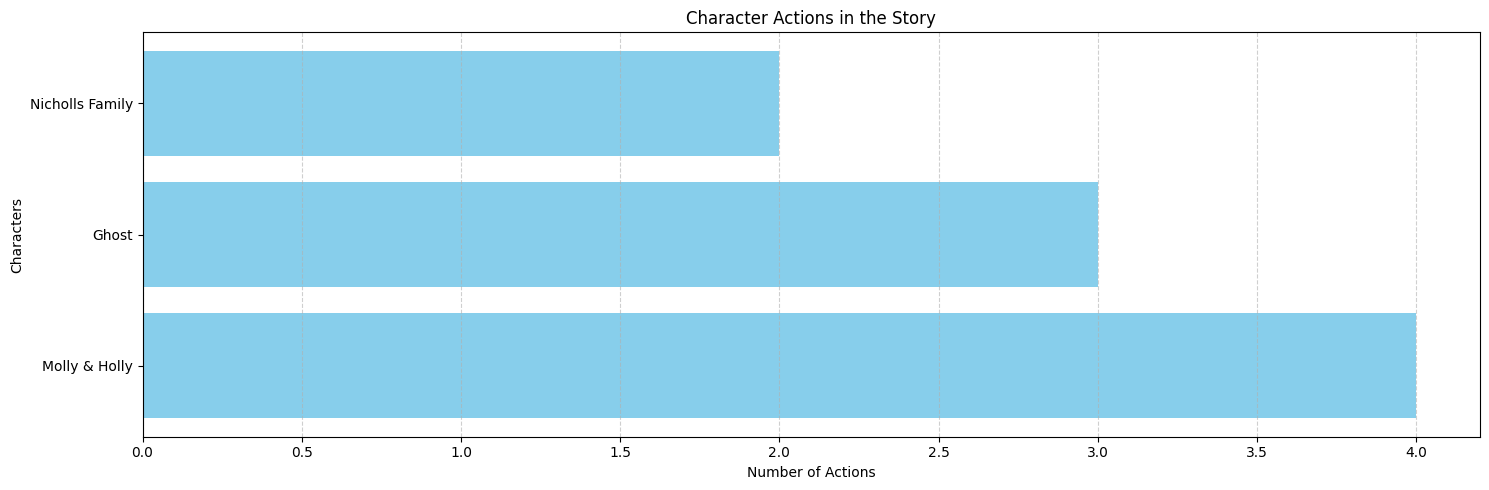

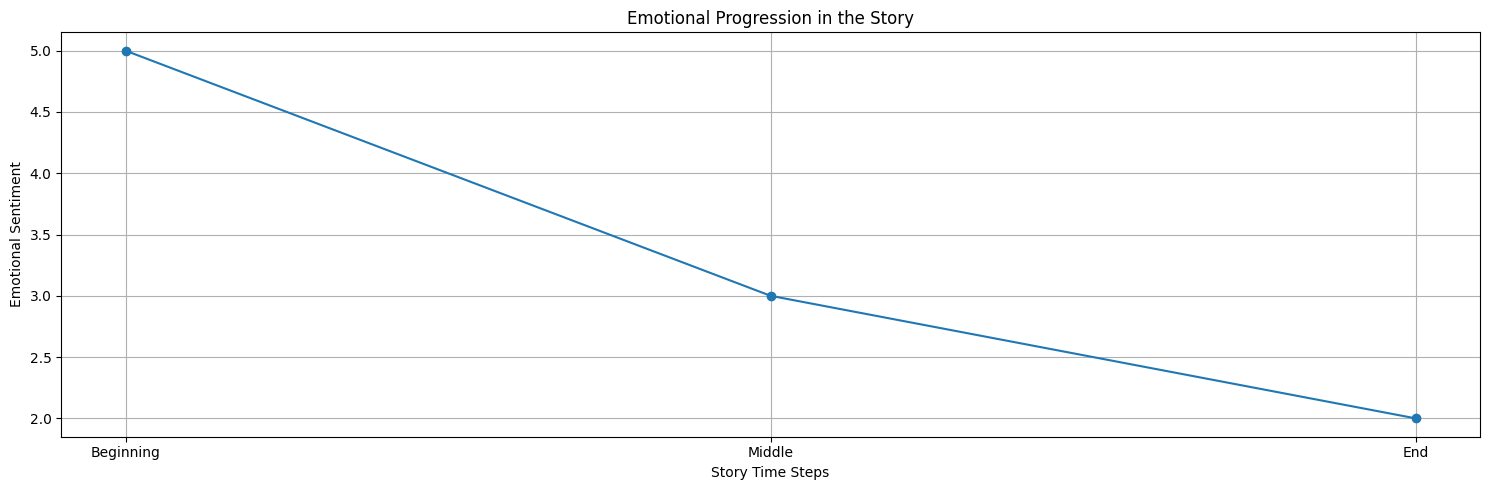

In [ ]:

plt.figure(figsize=(15, 5))

# Plot 1: Bar chart showing characters and their actions
actions = ["Sleeping", "Yowling", "Investigating", "Crying", "Helping"]
characters = ["Nicholls Family", "Ghost", "Molly & Holly"]
character_counts = [2, 3, 4]  # Adjusted to match the number of characters
# Adjust counts based on text analysis (if possible)

plt.barh(characters, character_counts, color='skyblue')
plt.xlabel("Number of Actions")
plt.ylabel("Characters")
plt.title("Character Actions in the Story")
plt.gca().invert_yaxis()  # Invert y-axis to display main characters on top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# Plot 2: Line chart showing emotional progression (assuming positive for happy, negative for scared/crying)
emotions = ["Positive", "Negative"]
emotion_values = [5, 3, 2]  # Adjust values based on text analysis (if possible)
time_steps = ["Beginning", "Middle", "End"]

plt.figure(figsize=(15, 5))
plt.plot(time_steps, emotion_values, marker='o', linestyle='-')
plt.xlabel("Story Time Steps")
plt.ylabel("Emotional Sentiment")
plt.title("Emotional Progression in the Story")
plt.grid(True)
plt.tight_layout()

plt.show()
